Importing libraries


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Maxwell PINN

In [2]:
torch.manual_seed(42)
np.random.seed(42)

#PINN model
class PINN_Maxwell(nn.Module):
    def __init__(self, num_hidden_layers=4, num_neurons_per_layer=40):
        super(PINN_Maxwell, self).__init__()
        self.num_hidden_layers = num_hidden_layers
        self.num_neurons_per_layer = num_neurons_per_layer

        layers = nn.ModuleList()
        layers.append(nn.Linear(3, num_neurons_per_layer))
        for _ in range(num_hidden_layers - 1):
            layers.append(nn.Linear(num_neurons_per_layer, num_neurons_per_layer))
        layers.append(nn.Linear(num_neurons_per_layer, 3))

        self.layers = layers
        self.activation = nn.Tanh()

    def forward(self, x):
        for i in range(self.num_hidden_layers):
            x = self.activation(self.layers[i](x))
        x = self.layers[-1](x)
        return x

COMPUTE PDE  Residuals

In [4]:
def compute_pde_residuals(inputs, model):
    x = inputs[:, 0:1]
    y = inputs[:, 1:2]
    t = inputs[:, 2:3]

    x.requires_grad = True
    y.requires_grad = True
    t.requires_grad = True

    outputs = model(torch.cat([x, y, t], dim=1))
    Ex = outputs[:, 0:1]
    Ey = outputs[:, 1:2]
    Hz = outputs[:, 2:3]

    dEx_dt = torch.autograd.grad(Ex, t, grad_outputs=torch.ones_like(Ex), create_graph=True)[0]
    dEy_dt = torch.autograd.grad(Ey, t, grad_outputs=torch.ones_like(Ey), create_graph=True)[0]
    dHz_dt = torch.autograd.grad(Hz, t, grad_outputs=torch.ones_like(Hz), create_graph=True)[0]

    dHz_dy = torch.autograd.grad(Hz, y, grad_outputs=torch.ones_like(Hz), create_graph=True)[0]
    dHz_dx = torch.autograd.grad(Hz, x, grad_outputs=torch.ones_like(Hz), create_graph=True)[0]
    dEy_dx = torch.autograd.grad(Ey, x, grad_outputs=torch.ones_like(Ey), create_graph=True)[0]
    dEx_dy = torch.autograd.grad(Ex, y, grad_outputs=torch.ones_like(Ex), create_graph=True)[0]

    epsilon = 1.0
    mu = 1.0

    eq1 = dEx_dt - (1/epsilon) * dHz_dy
    eq2 = dEy_dt + (1/epsilon) * dHz_dx
    eq3 = dHz_dt - (1/mu) * (dEy_dx - dEx_dy)

    return eq1, eq2, eq3

In [5]:
# Initial condition function
def initial_condition(x, y):
    Hz_init = torch.exp(-((x**2 + y**2) / 0.1))
    Ex_init = torch.zeros_like(x)
    Ey_init = torch.zeros_like(y)
    return Ex_init, Ey_init, Hz_init

LOSS function

In [6]:
def loss_fn(model, data):

    inputs_interior = torch.cat(data['interior'], dim=1)
    x_initial, y_initial = data['initial_coords']
    t_initial = torch.zeros_like(x_initial)

    # PDE Loss
    eq1, eq2, eq3 = compute_pde_residuals(inputs_interior, model)
    loss_pde = torch.mean(eq1**2) + torch.mean(eq2**2) + torch.mean(eq3**2)

    # Initial Condition Loss
    Ex_init_true, Ey_init_true, Hz_init_true = initial_condition(x_initial, y_initial)
    inputs_initial = torch.cat([x_initial, y_initial, t_initial], dim=1)
    outputs_initial = model(inputs_initial)
    Ex_init_pred = outputs_initial[:, 0:1]
    Ey_init_pred = outputs_initial[:, 1:2]
    Hz_init_pred = outputs_initial[:, 2:3]

    loss_init_Ex = torch.mean((Ex_init_pred - Ex_init_true)**2)
    loss_init_Ey = torch.mean((Ey_init_pred - Ey_init_true)**2)
    loss_init_Hz = torch.mean((Hz_init_pred - Hz_init_true)**2)
    loss_init = loss_init_Ex + loss_init_Ey + loss_init_Hz

    total_loss = loss_pde + loss_init
    return total_loss, loss_pde, loss_init

Training

In [8]:
def train(model, data, epochs=2000, lr=5e-4, log_frequency=100):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    history = {'loss': [], 'loss_pde': [], 'loss_init': []}

    for epoch in range(epochs):
        optimizer.zero_grad()
        loss, loss_pde, loss_init = loss_fn(model, data)
        loss.backward()
        optimizer.step()

        history['loss'].append(loss.item())
        history['loss_pde'].append(loss_pde.item())
        history['loss_init'].append(loss_init.item())

        if epoch % log_frequency == 0:
            print(f"Epoch {epoch}, Total Loss: {loss.item():.4e}, PDE Loss: {loss_pde.item():.4e}, Initial Loss: {loss_init.item():.4e}")

    return model, history

Test

In [10]:
# Test function
def test_model(model, t_test_val=0.1, spatial_domain=[-2, 2], num_points=50):

    x_test = torch.linspace(spatial_domain[0], spatial_domain[1], num_points).view(-1, 1)
    y_test = torch.linspace(spatial_domain[0], spatial_domain[1], num_points).view(-1, 1)
    t_test = torch.tensor([[t_test_val]])

    X_test, Y_test = torch.meshgrid(x_test.squeeze(), y_test.squeeze(), indexing='ij')

    X_test_flat = X_test.reshape(-1, 1)
    Y_test_flat = Y_test.reshape(-1, 1)
    T_test_flat = t_test.repeat(X_test_flat.shape[0], 1)

    inputs_test = torch.cat([X_test_flat, Y_test_flat, T_test_flat], dim=1)
    outputs_test = model(inputs_test)

    Ex_pred = outputs_test[:, 0].reshape(num_points, num_points).detach().numpy()
    Ey_pred = outputs_test[:, 1].reshape(num_points, num_points).detach().numpy()
    Hz_pred = outputs_test[:, 2].reshape(num_points, num_points).detach().numpy()

    return X_test.numpy(), Y_test.numpy(), Ex_pred, Ey_pred, Hz_pred

Running the model

Epoch 0, Total Loss: 3.0057e-02, PDE Loss: 2.8288e-03, Initial Loss: 2.7228e-02
Epoch 500, Total Loss: 6.3471e-03, PDE Loss: 3.3397e-04, Initial Loss: 6.0131e-03
Epoch 1000, Total Loss: 5.2862e-03, PDE Loss: 7.0076e-04, Initial Loss: 4.5854e-03
Epoch 1500, Total Loss: 4.4516e-03, PDE Loss: 8.3441e-04, Initial Loss: 3.6172e-03
Epoch 2000, Total Loss: 3.4925e-03, PDE Loss: 7.7356e-04, Initial Loss: 2.7189e-03
Epoch 2500, Total Loss: 2.8233e-03, PDE Loss: 7.6595e-04, Initial Loss: 2.0573e-03
Epoch 3000, Total Loss: 2.0814e-03, PDE Loss: 6.8963e-04, Initial Loss: 1.3918e-03
Epoch 3500, Total Loss: 1.3598e-03, PDE Loss: 4.9170e-04, Initial Loss: 8.6813e-04
Epoch 4000, Total Loss: 9.5381e-04, PDE Loss: 3.4993e-04, Initial Loss: 6.0388e-04
Epoch 4500, Total Loss: 7.0487e-04, PDE Loss: 2.6162e-04, Initial Loss: 4.4325e-04


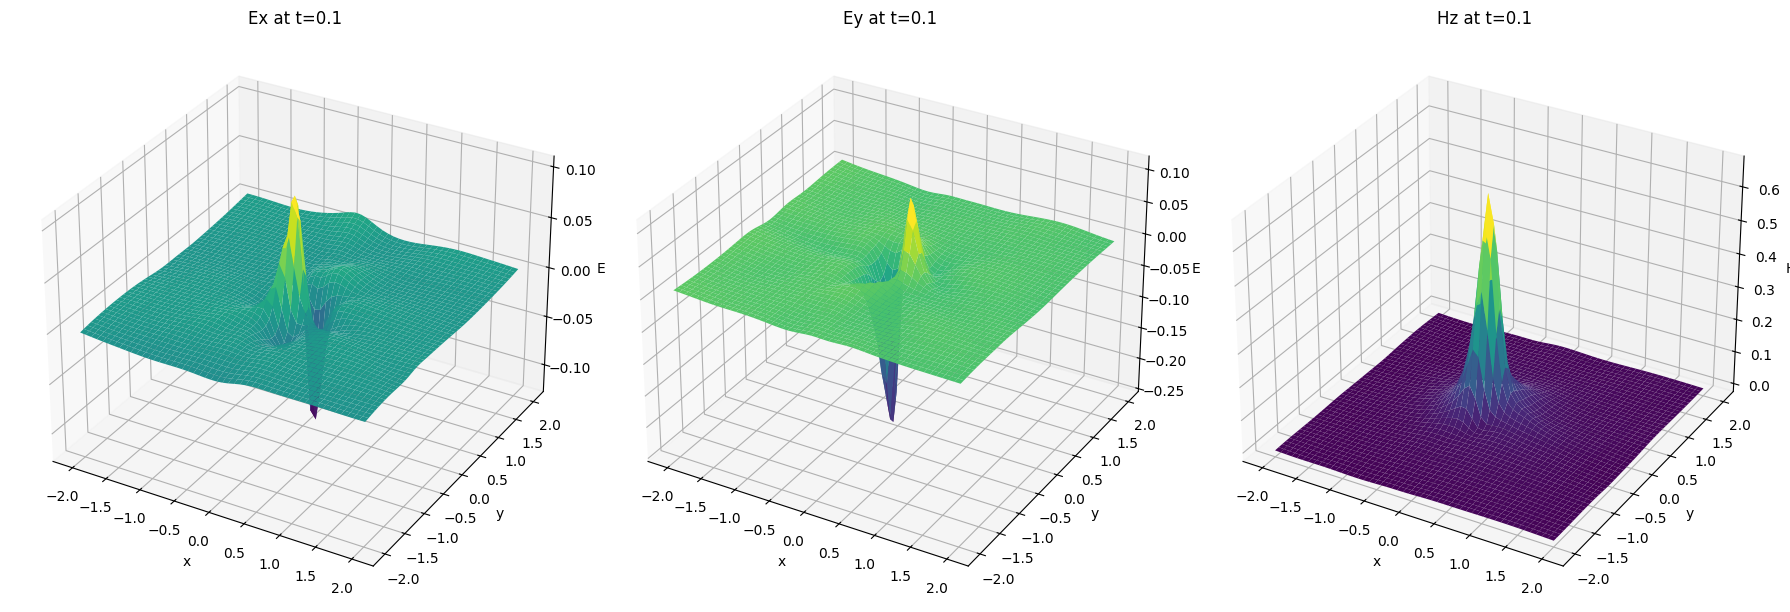

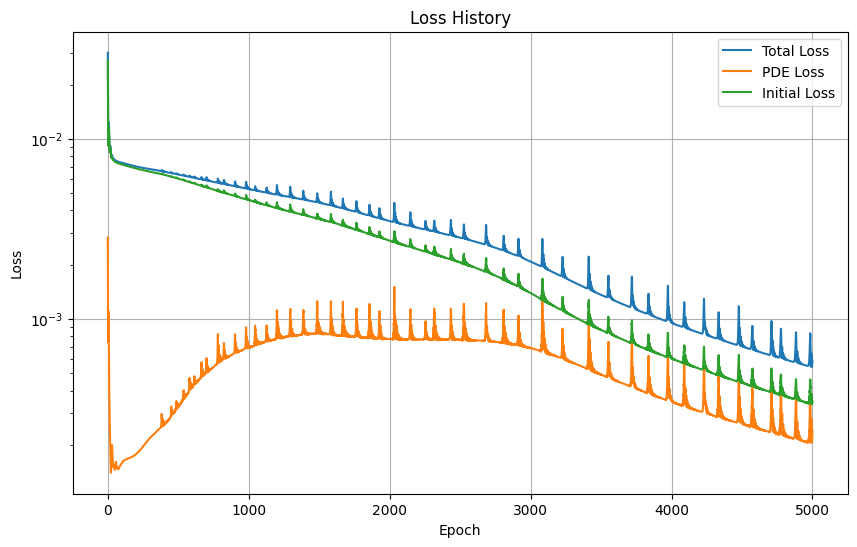

In [11]:
# Model parameters
num_hidden_layers = 4
num_neurons_per_layer = 40
learning_rate = 1e-3
num_epochs = 5000
log_frequency = 500

#spatial and temporal domains
spatial_domain = [-2, 2]
temporal_domain = [0, 1]

# Number of collocation points
num_interior_points = 2000
num_initial_points = 1000

# Generate training data
def generate_data(num_interior, num_initial, spatial_domain, temporal_domain):
    # Interior points (x, y, t)
    x_interior = torch.rand(num_interior, 1) * (spatial_domain[1] - spatial_domain[0]) + spatial_domain[0]
    y_interior = torch.rand(num_interior, 1) * (spatial_domain[1] - spatial_domain[0]) + spatial_domain[0]
    t_interior = torch.rand(num_interior, 1) * (temporal_domain[1] - temporal_domain[0]) + temporal_domain[0]
    interior_data = (x_interior, y_interior, t_interior)

    # Initial points (x, y) at t=0
    x_initial = torch.rand(num_initial, 1) * (spatial_domain[1] - spatial_domain[0]) + spatial_domain[0]
    y_initial = torch.rand(num_initial, 1) * (spatial_domain[1] - spatial_domain[0]) + spatial_domain[0]
    initial_coords = (x_initial, y_initial)

    data = {'interior': interior_data, 'initial_coords': initial_coords}
    return data

data = generate_data(num_interior_points, num_initial_points, spatial_domain, temporal_domain)

# Initialize the model
model = PINN_Maxwell(num_hidden_layers, num_neurons_per_layer)

# Train the model
trained_model, history = train(model, data, epochs=num_epochs, lr=learning_rate, log_frequency=log_frequency)

# Test the model at t=0.1
x_test, y_test, Ex_pred, Ey_pred, Hz_pred = test_model(trained_model, t_test_val=0.1, spatial_domain=spatial_domain)

#Visualization
def plot_results(X, Y, Ex, Ey, Hz, t_val):
    fig = plt.figure(figsize=(18, 6))

    # Plot Ex
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.plot_surface(X, Y, Ex, cmap='viridis')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_zlabel('Ex')
    ax1.set_title(f'Ex at t={t_val}')

    # Plot Ey
    ax2 = fig.add_subplot(132, projection='3d')
    ax2.plot_surface(X, Y, Ey, cmap='viridis')
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_zlabel('Ey')
    ax2.set_title(f'Ey at t={t_val}')

    # Plot Hz
    ax3 = fig.add_subplot(133, projection='3d')
    ax3.plot_surface(X, Y, Hz, cmap='viridis')
    ax3.set_xlabel('x')
    ax3.set_ylabel('y')
    ax3.set_zlabel('Hz')
    ax3.set_title(f'Hz at t={t_val}')

    plt.tight_layout()
    plt.show()

t_test_value_for_plot = 0.1
plot_results(x_test, y_test, Ex_pred, Ey_pred, Hz_pred, t_test_value_for_plot)

# Plotting the loss history
plt.figure(figsize=(10, 6))
plt.plot(history['loss'], label='Total Loss')
plt.plot(history['loss_pde'], label='PDE Loss')
plt.plot(history['loss_init'], label='Initial Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss History')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.show()